In [1]:
import sys
import os
import pandas
import numpy as np 
import io 
from rdkit import Chem
sys.path.append("../")
import mol_cv
import load_medchem_data
import predict_medchem
import cv_plot
import PIL

<frozen importlib._bootstrap>:488: RuntimeWarning: to-Python converter for boost::shared_ptr<RDKit::FilterHierarchyMatcher> already registered; second conversion method ignored.
<frozen importlib._bootstrap>:488: RuntimeWarning: to-Python converter for boost::shared_ptr<RDKit::FilterCatalogEntry> already registered; second conversion method ignored.


In [2]:
predictor_dict = predict_medchem.all_predictors()

In [3]:
fda = load_medchem_data.load_fda_drugs()
fda["cluster"] = predict_medchem.cluster(mols=fda["mol"],fingerprint_size=1024,cutoff=0.5)

Getting distances: 100%|██████████████████████████████████████████████████████████████████████████| 1613/1613 [00:00<00:00, 4983.56it/s]


In [4]:
from rdkit.Chem.rdMolAlign import AlignMol
from rdkit.Chem import rdFMCS, AllChem, MolToSmiles, rdDepictor
from rdkit.Chem.Draw.rdMolDraw2D import PrepareMolForDrawing
from rdkit.Geometry.rdGeometry import Point2D

def align_cluster(cluster_1):
    mols = list(cluster_1["mol"])
    # see https://github.com/rdkit/rdkit/discussions/4120
    mcs = rdFMCS.FindMCS(mols)
    template = Chem.MolFromSmarts(mcs.smartsString)
    AllChem.Compute2DCoords(template) #coordMap={0:Point2D(0,0])})
    PrepareMolForDrawing(template)
    for m in mols:
        AllChem.GenerateDepictionMatching2DStructure(m , template)


In [5]:
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem.Draw import MolsToGridImage
from collections import Counter
counter = Counter(fda["cluster"])
fda["cluster_size"] = fda["cluster"].map(counter)
cluster_1 = fda[fda["cluster"] == 2]
align_cluster(cluster_1)
# see https://www.rdkit.org/docs/source/rdkit.Chem.Draw.rdMolDraw2D.html#rdkit.Chem.Draw.rdMolDraw2D.MolDrawOptions
dopts = rdMolDraw2D.MolDrawOptions()
dopts.drawMolsSameScale = False
dopts.fixedScale = 0.05
dopts.centreMoleculesBeforeDrawing = False
image_height = 200
image_width= 400
mols = list(cluster_1["mol"])
png_grid = MolsToGridImage(mols,drawOptions=dopts,molsPerRow=1,
                           subImgSize=(image_width, image_height),returnPNG=False)
png_array = np.array(png_grid)
individual_images = [png_array[i*image_height:(i+1)*image_height,:,:]
                     for i in range(len(mols))]

/opt/anaconda3/envs/mol_cv/lib/ruby/3.4.0/rubygems/basic_specification.rb:243:in 'Gem::BasicSpecification#internal_init': Interrupt
	from /opt/anaconda3/envs/mol_cv/lib/ruby/3.4.0/rubygems/specification.rb:2096:in 'Gem::Specification#internal_init'
	from /opt/anaconda3/envs/mol_cv/lib/ruby/3.4.0/rubygems/basic_specification.rb:34:in 'Gem::BasicSpecification#initialize'
	from /opt/anaconda3/envs/mol_cv/lib/ruby/3.4.0/rubygems/specification.rb:1987:in 'Gem::Specification#initialize'
	from /opt/anaconda3/envs/mol_cv/lib/ruby/gems/3.4.0/specifications/default/ruby2_keywords-0.0.5.gemspec:4:in 'Class#new'
	from /opt/anaconda3/envs/mol_cv/lib/ruby/gems/3.4.0/specifications/default/ruby2_keywords-0.0.5.gemspec:4:in 'Gem::Specification.load'
	from /opt/anaconda3/envs/mol_cv/lib/ruby/3.4.0/rubygems/specification.rb:1093:in 'Kernel#eval'
	from /opt/anaconda3/envs/mol_cv/lib/ruby/3.4.0/rubygems/specification.rb:1093:in 'Gem::Specification.load'
	from /opt/anaconda3/envs/mol_cv/lib/ruby/3.4.0/ruby

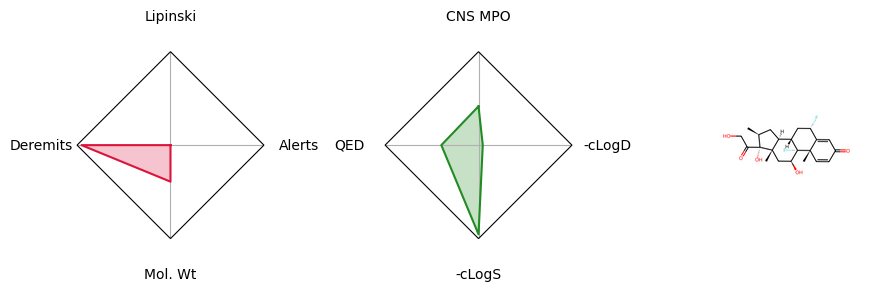

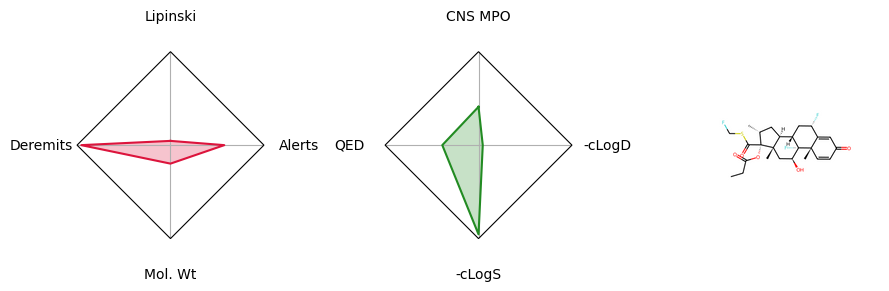

In [ ]:
%%capture
# previous line prevents output from displaying in cell
images = []
for mol,image in zip(cluster_1["mol"],individual_images):
    row = mol_cv.calculate_properties(mol,predictor_dict)
    fig = cv_plot.cv_plot(row,image_mol=image)
    buf = io.BytesIO()
    fig.savefig(buf)
    buf.seek(0)
    images.append(PIL.Image.open(buf))
images[0].save('animated_plot.gif', save_all=True, append_images=images, duration=500, loop=0)